In [1]:
!pip install -q datasets transformers
import os

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
import huggingface_hub

In [ ]:
huggingface_hub.whoami()

In [6]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
from datasets import load_dataset
data = load_dataset("/kaggle/input/bangladeshi-folk-musical-instruments-imagedataset/bangladeshi_folk_musical_instruments_images")

In [14]:
ex = data['train'][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=850x923>,
 'label': 0}

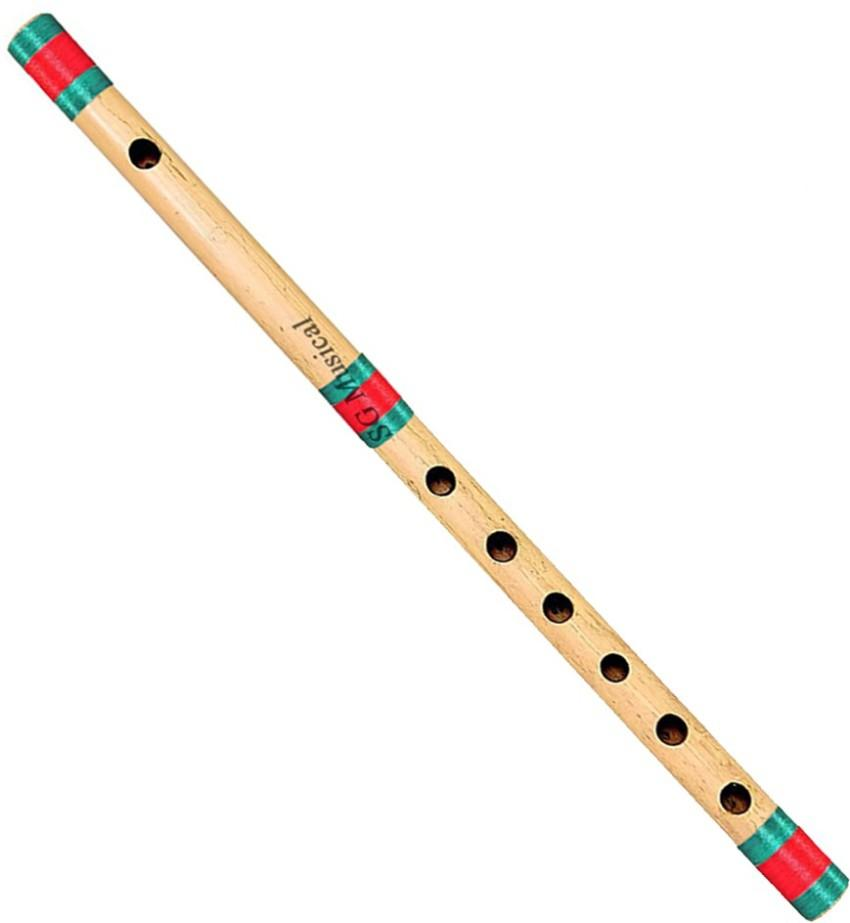

In [15]:
image = ex['image']
image

In [16]:
labels = data['train'].features['label']
labels

ClassLabel(names=['Bashi', 'Bina', 'Dhol', 'Dotara', 'Ektara', 'Esraj', 'Harmonium', 'Kashor', 'Khol', 'Madal', 'Manjira', 'Sharinda', 'Sitar', 'Tabla', 'Tanpura'], id=None)

In [17]:
labels.int2str(ex['label'])

'Bashi'

In [18]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00


In [19]:
import evaluate
accuracy = evaluate.load("accuracy")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [20]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2771
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 489
    })
})

In [21]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [22]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [23]:
h = feature_extractor.size['height']
w = feature_extractor.size['width']

In [24]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop([h,w]),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize([h,w]),
            CenterCrop([h,w]),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [25]:
# split up training into training + validation

train_N_val_split = data['train'].train_test_split(test_size=0.2)
train_ds = train_N_val_split['train']
val_ds = train_N_val_split['test']

test_ds=data['test']

In [26]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_val)

In [27]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=459x612>,
 'label': 4,
 'pixel_values': tensor([[[0.1843, 0.1922, 0.1843,  ..., 0.2549, 0.2627, 0.2549],
          [0.2000, 0.2078, 0.1922,  ..., 0.2706, 0.2784, 0.2706],
          [0.1922, 0.1922, 0.1922,  ..., 0.2706, 0.2706, 0.2706],
          ...,
          [0.2784, 0.2784, 0.2784,  ..., 0.2235, 0.2157, 0.2157],
          [0.2784, 0.2784, 0.2784,  ..., 0.2235, 0.2235, 0.2157],
          [0.2784, 0.2784, 0.2784,  ..., 0.2314, 0.2235, 0.2235]],
 
         [[0.2000, 0.2078, 0.2000,  ..., 0.2627, 0.2627, 0.2549],
          [0.2157, 0.2235, 0.2078,  ..., 0.2706, 0.2784, 0.2706],
          [0.2078, 0.2078, 0.2078,  ..., 0.2706, 0.2706, 0.2706],
          ...,
          [0.2706, 0.2706, 0.2706,  ..., 0.2157, 0.2078, 0.2078],
          [0.2706, 0.2706, 0.2706,  ..., 0.2157, 0.2157, 0.2078],
          [0.2706, 0.2706, 0.2706,  ..., 0.2235, 0.2157, 0.2157]],
 
         [[0.1922, 0.2000, 0.1922,  ..., 0.2784, 0.2784, 0.2706],
  

In [28]:
from transformers import ViTForImageClassification
model_name_or_path = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  'finetuned-bangladeshi-folk-musical-instrument-vit',
  per_device_train_batch_size=16,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
  hub_strategy="end"
)#

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

In [31]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [32]:
from transformers import Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/tmp/ipykernel_23/963735583.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_results = trainer.train()

trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.820000,0.672107,0.908108
2,0.417400,0.385147,0.927928
3,0.359700,0.345538,0.920721
4,0.238400,0.282088,0.938739


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

events.out.tfevents.1743315892.ebcba6f1789e.23.0:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 639789764GF
  train_loss               =      0.6311
  train_runtime            =  0:05:13.87
  train_samples_per_second =       28.24
  train_steps_per_second   =       0.892


We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [34]:
log_history = trainer.state.log_history
log_history

[{'loss': 2.4824,
  'grad_norm': 104734.34375,
  'learning_rate': 0.00019285714285714286,
  'epoch': 0.14285714285714285,
  'step': 10},
 {'loss': 1.957,
  'grad_norm': 98351.5703125,
  'learning_rate': 0.00018571428571428572,
  'epoch': 0.2857142857142857,
  'step': 20},
 {'loss': 1.5282,
  'grad_norm': 100968.1875,
  'learning_rate': 0.0001785714285714286,
  'epoch': 0.42857142857142855,
  'step': 30},
 {'loss': 1.2422,
  'grad_norm': 100465.953125,
  'learning_rate': 0.00017142857142857143,
  'epoch': 0.5714285714285714,
  'step': 40},
 {'loss': 0.971,
  'grad_norm': 97952.1875,
  'learning_rate': 0.00016428571428571428,
  'epoch': 0.7142857142857143,
  'step': 50},
 {'loss': 0.9229,
  'grad_norm': 119173.234375,
  'learning_rate': 0.00015714285714285716,
  'epoch': 0.8571428571428571,
  'step': 60},
 {'loss': 0.82,
  'grad_norm': 126560.7109375,
  'learning_rate': 0.00015000000000000001,
  'epoch': 1.0,
  'step': 70},
 {'eval_loss': 0.6721073985099792,
  'eval_accuracy': 0.90810810

In [ ]:
predictions = trainer.predict(test_ds)

In [57]:
predictions

PredictionOutput(predictions=array([[-0.6489258 , -0.47509766, -0.7739258 , ..., -0.03442383,
        -0.6972656 , -0.04800415],
       [-0.36547852,  0.18310547, -0.30126953, ..., -0.43725586,
        -0.8408203 , -0.71435547],
       [-0.8803711 , -0.70751953, -0.09667969, ..., -0.30541992,
        -0.41308594,  0.23620605],
       ...,
       [-0.5253906 , -0.22705078, -0.46142578, ..., -0.6791992 ,
        -0.46875   , -0.25146484],
       [-1.0947266 , -1.1308594 , -1.0185547 , ..., -0.31176758,
        -0.46899414, -0.6147461 ],
       [-0.52734375,  0.47802734, -0.31298828, ..., -0.37426758,
        -0.85058594, -0.3244629 ]], dtype=float32), label_ids=array([ 3, 10,  3,  5,  8,  2,  7,  3,  3,  4,  7,  3,  2, 10,  0,  4,  5,
        4, 10, 11,  0,  8,  0,  7, 10,  6, 12, 13, 10, 11,  3,  0,  5,  9,
        0, 12, 10,  4,  0, 10, 14,  0,  8, 11,  8,  5,  2,  4, 11, 10,  3,
        2, 10,  8, 12,  3, 12,  4,  4,  8,  1, 12, 11,  1, 10,  9,  1,  6,
        6,  5,  4,  4,  5, 11,  

In [35]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9387
  eval_loss               =     0.2821
  eval_runtime            = 0:00:09.98
  eval_samples_per_second =     55.566
  eval_steps_per_second   =      3.504


In [ ]:
predictions_output = trainer.predict(test_ds)

logits = predictions_output.predictions
predictions = np.argmax(logits, axis=1)  
true_labels = predictions_output.label_ids 

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
labels = test_ds.features["label"].names  
cm = confusion_matrix(true_labels, predictions, labels=range(len(labels)))

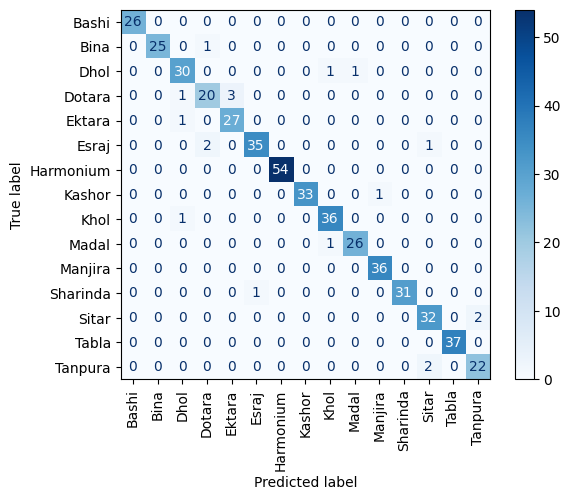

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()